# Trabajo pr√°ctico integrador Comunicaciones digitales

Alumnos:
- Krede Julian
- Pi√±era, Nicolas

---

## Introducci√≥n

Este trabajo pr√°ctico tiene como objetivo analizar el funcionamiento de la capa f√≠sica (PHY) de la modulaci√≥n LoRa, empleada en el sistema de comunicaci√≥n LoRaWAN, una red de tipo LPWAN (Low Power Wide Area Network).\
Una red tipo LPWAN es una red de telecomunicaciones dise√±ada espec√≠ficamente para la comunicaci√≥n de dispositivos que requieren cobertura de largo alcance y bajo consumo energ√©tico, caracter√≠sticas fundamentales en aplicaciones de Internet de las Cosas (IoT).\
Este tipo de redes est√° dise√±ada para transmitir datos de baja frecuencia (como mensajes de texto o lecturas de sensores simples), donde no se requiere una alta tasa de transmisi√≥n de bits (low data rate). Esto se debe a que, en LPWAN, la tasa de transmisi√≥n (data rate) y el alcance (range) tienen una relaci√≥n inversa con el ancho de banda utilizado.\
Esta relaci√≥n inversa entre tasa de datos, alcance y ancho de banda est√° fundamentada en el teorema de Shannon-Hartley, que define los l√≠mites te√≥ricos de capacidad del canal en funci√≥n del ancho de banda y la calidad de la se√±al (SNR).


In [52]:
## Librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt


---

## 1. Fuente de mensajes


El mensaje transmitido consiste en una secuencia de bits. Para modelar estas secuencias, se define una variable aleatoria discreta $X$ con distribuci√≥n uniforme $X \sim \operatorname{U}(0,1)$, donde $P(X=0) = P(X=1) = 0.5$.


In [53]:
def generador_bits_aleatorios(total_bits):
    """
    Genera un vector de bits aleatorios (0 y 1) de longitud especificada.

    Args:
        cantidad_Bits(int) : Cantidad de bits a generar.

    Returns:
        bits_transmitidos(Array) : Vector de bits aleatorios (0 y 1).
    """
    return np.random.randint(0, 2, total_bits)

---

## 2. Codificador y Decodificador

### 2.1 Codificador

El codificador recibe como entrada el mensaje o hipotesis y produce como salida una palabra clave (codeword), que en el contexto de [1] se denomina "s√≠mbolo".\
La codificaci√≥n propuesta en [1] se realiza mediante el polinomio de numeraci√≥n posicional en base 2. Para ello, se requiere la elecci√≥n de un par√°metro conocido como Spreading Factor ($SF$), el cual puede tomar los siguientes valores enteros:
$$SF\in \{7,8,9,10,11,12\}$$
Este par√°metro determina la cantidad de d√≠gitos binarios (bits) que conforman un s√≠mbolo.\
Para transformar una secuencia de bits en un s√≠mbolo, se utiliza la siguiente ecuaci√≥n:

$$\Large s(nT_s) = \sum_{h=0}^{\text{SF}-1} \text{w}(nT_s)_h \cdot 2^h$$

Donde:
- $s(nT_s)$: S√≠mbolo resultante (valor decimal).
- $\text{w}(nT_s)_h$: D√≠gito binario (0 o 1) en la posici√≥n $h$.
- $2^h$: Peso posicional del bit.
- $T_s$: Duraci√≥n de un s√≠mbolo en el tiempo.
- $n$: √çndice temporal de la secuencia de s√≠mbolos.

Ejemplo:\
Si se configura $SF = 8$ y se codifica la secuencia binaria:
$$[0\ 1\ 1\ 1\ 1\ 0\ 0\ 0]$$ 
El s√≠mbolo resultante se calcula como:
$$s(nT_s) = \sum_{h=0}^{7} \text{w}(nT_s)_h \cdot 2^h = 0 \cdot 2^7 + 1 \cdot 2^6 + 1 \cdot 2^5 + 1 \cdot 2^4 + 1 \cdot 2^3 + 0 \cdot 2^2 + 0 \cdot 2^1 + 0 \cdot 2^0 = 120$$


In [54]:
def codificador(bits_transmitidos, SF):
    """
    Codifica un se√±al binaria mediante el polinomio de numeraci√≥n posicional en base 2

    Args:
        bits_transmitidos (array): Vector de bits a transmitir
        SF (int): Spreading Factor

    Returns:
        simbolos (array): vector de simbolos codificados
    """
    cantidad_Bits = len(bits_transmitidos)  # Cantidad de bits transmitidos

    # Numero de simbolos a transmitir
    numero_de_simbolos = cantidad_Bits // SF

    # Vector de ceros con la longitud de la cantidad de simbolos
    simbolos = np.zeros(numero_de_simbolos, dtype=int)

    # Sumatoria - Ecuacion 1
    ## Simbolo i
    for i in range(numero_de_simbolos):

        # de 0 hasta SF-1
        for h in range(SF):
            "Toma bits dentro de un bloque de bits de largo SF"
            "Luego se suma cada bit con su peso para obtener el valor decimal del simbolo a transmitir"

            bit = bits_transmitidos[i * SF + h]  # Va desde el LSB al MSB
            simbolos[i] += bit * (2**h)  # Conversion a decimal

    return simbolos


### 2.2 Decodificador

El decodificador recibe como entrada la observaci√≥n o estad√≠stico suficiente y produce como salida una hipotesis estimada. Para esto, el decodificador implementa el algoritmo de divisiones sucesivas por 2 (base binaria) para recuperar el dato a partir del s√≠mbolo recibido. El procedimiento consiste en dividir el n√∫mero original entre 2 de forma repetida. En cada divisi√≥n, se registra el residuo o m√≥dulo (que siempre ser√° 0 o 1), y se reemplaza el n√∫mero por el cociente entero obtenido. Este proceso se repite hasta que el cociente sea igual a cero. Finalmente, el n√∫mero binario se construye leyendo los residuos en orden inverso al que fueron generados; es decir, desde el √∫ltimo hasta el primero.

$$\large \mathbf{w}(nT_s)_h = \left( \left\lfloor \frac{s(nT_s)}{2^h} \right\rfloor \bmod 2 \right), \quad h = 0, 1, \dots, SF - 1$$

$$\mathbf{w}(nT_s) = \left[
\left\lfloor \frac{s(nT_s)}{2^0} \right\rfloor \bmod 2,\ 
\left\lfloor \frac{s(nT_s)}{2^1} \right\rfloor \bmod 2,\ 
\ldots,\ 
\left\lfloor \frac{s(nT_s)}{2^{SF - 1}} \right\rfloor \bmod 2
\right]$$

In [55]:
def decodificador(simbolos_recibidos, SF):
    """
    Decodifica una se√±al binaria mediante el polinomio de numeraci√≥n posicional en base 2

    Args:
        SF (int): Spreading factor
        simbolos_recibidos (array): Vector de simbolos recibidos

    Returns:
        bits_rx (array): Vector bits decodificados.
    """
    if SF < 7 or SF > 12:
        raise ValueError("El Spreading Factor debe ser un valor entero entre 7 y 12")

    bits_rx = []

    for simbolo in simbolos_recibidos:  # Se toma cada simbolo
        bits = []
        for _ in range(SF):  # Se repite la division por 2 hasta SF-1
            bits.append(simbolo % 2)
            simbolo = simbolo // 2
        bits_rx.extend(bits)  # Agrega los bits en orden LSB a MSB

    return np.array(bits_rx, dtype=int)  # Asegura que sea un array plano de enteros


### 2.3 Bit error rate

El _Bit Error Rate_ (BER) representa la proporci√≥n de bits recibidos con errores respecto al total de bits transmitidos. Se calcula mediante la siguiente f√≥rmula:
$$BER=\frac{\text{n√∫mero de bits err√≥neos}}{\text{total de bits transmitidos}}$$

In [56]:
def calculador_ber(bits_tx, bits_rx):
    """
    Calcula la tasa de error de bit (BER) entre los bits transmitidos y recibidos.

    Args:
        bits_tx (list): Arreglo unidimensional de bits transmitidos.
        bits_rx (list): Arreglo unidimensional de bits recibidos.

    Returns:
        BER (float): Tasa de error de bit (BER).
    """
    if len(bits_tx) != len(bits_rx):
        raise ValueError("Los arreglos de bits transmitidos y recibidos deben tener la misma longitud.")

    errores = np.sum(bits_tx != bits_rx)
    ber = errores / len(bits_tx)

    return ber


### 2.4 Histograma de s√≠mbolos

Implementaci√≥n de una funci√≥n que grafica el histograma de los s√≠mbolos codificados, mostrando la frecuencia de aparici√≥n de los diferentes valores de s√≠mbolos.

In [57]:
def graficar_histograma(simbolos_codificados):
    """
    Grafica el histograma de los s√≠mbolos codificados.

    Args:
        simbolos_codificados (list or array): Lista o array de s√≠mbolos codificados.
    """
    plt.figure(figsize=(18, 6))  # Aumenta el tama√±o de la figura
    bins = range(min(simbolos_codificados), max(simbolos_codificados) + 2)
    plt.hist(simbolos_codificados, bins=bins, align='left', rwidth=0.85, color='skyblue', edgecolor='black')
    plt.xlabel('S√≠mbolo', fontsize=16)
    plt.ylabel('Frecuencia', fontsize=16)
    plt.title('Histograma de s√≠mbolos codificados', fontsize=18)
    step = 8
    plt.xticks(bins[::step], fontsize=12, rotation=45)
    max_frecuencia = int(max([p.get_height() for p in plt.gca().patches]))
    plt.yticks(np.arange(0, max_frecuencia + 1, 1), fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### 2.5 Prueba de funcionamiento

A continuaci√≥n se realiza una prueba estad√≠stica para verificar el correcto funcionamiento de las funciones implementadas.\
El criterio de validaci√≥n adoptado consisti√≥ en generar una cantidad suficiente de s√≠mbolos aleatorios (exactamente $2^{SF}$ muestras), lo que garantiza probabil√≠sticamente que todos los posibles s√≠mbolos en el rango $[0, 2^{SF}-1]$ tengan alta probabilidad de aparecer al menos una vez.

In [58]:
# Definici√≥n de par√°metros para la prueba

SF = 8                                  # Spreading Factor (debe ser un valor entre 7 y 12)
cant_simbolos = 2**SF                   # Cantidad de s√≠mbolos a transmitir
total_bits = SF * cant_simbolos         # Total de bits a transmitir


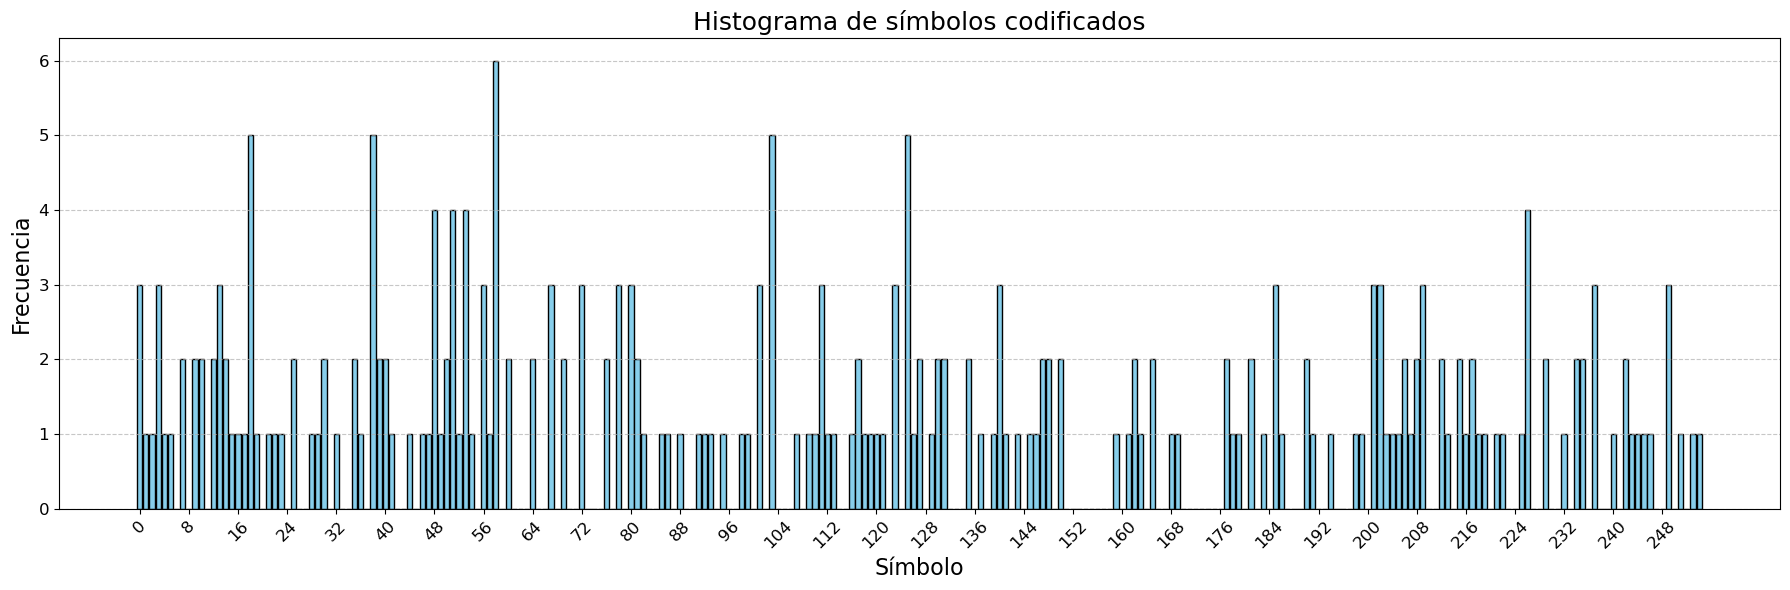

------------------------------
Bits originales (muestra primeros 30 bits):    [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0]
Bits decodificados (muestra primeros 30 bits): [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0]
La tasa de error de bit (BER) es:  0.0 %
------------------------------


In [59]:
# Se generan los bits aleatorios a transmitir
bits_tx = generador_bits_aleatorios(total_bits)

# Codificaci√≥n de los bits transmitidos
simbolos_rx = codificador(bits_tx, SF)

# Decodificaci√≥n de los s√≠mbolos recibidos
bits_rx = decodificador(simbolos_rx, SF)

# Calculo de la tasa de error de bit (BER)
ber = calculador_ber(bits_tx, bits_rx)

# Grafica el histograma de los s√≠mbolos codificados
graficar_histograma(simbolos_rx)

print("---" * 10)
print("Bits originales (muestra primeros 30 bits):   ", bits_tx[0:30])
print("Bits decodificados (muestra primeros 30 bits):", bits_rx[0:30])
print("La tasa de error de bit (BER) es: ", ber * 100, "%")
print("---" * 10)


---

## 2. Conformador de onda y conformador de n-tuplas

### 2.1 Conformador de onda

El conformador de onda (waveform former) es la etapa posterior al codificador en el transmisor. Recibe la salida del codificador (s√≠mbolos o palabras clave) y genera formas de onda mediante la modulaci√≥n **Frequency Shift Chirp Modulation** (FSCM).

__Funcionamiento__

Cada s√≠mbolo $s(nT_s)$ se asocia a una frecuencia inicial, a partir de la cual la se√±al modulada realiza un barrido lineal en frecuencia (chirp). Este barrido sigue la secuencia:
1. La frecuencia aumenta linealmente con el tiempo, siguiendo el √≠ndice $k = 0, 1, \dots, 2^{SF}-1$.
2. Alcanza un valor m√°ximo de $2^{SF}-1$.
3. La frecuencia decae abruptamente a $0$ y vuelve a incrementarse hasta retomar el valor inicial $s(nT_s)$. Completa as√≠ el per√≠odo del s√≠mbolo $T_s$.

__Representaci√≥n Matem√°tica__

Como se observa en [1] (secci√≥n _II_ ecuaci√≥n _(2)_), la modulaci√≥n se implementa con una se√±al compleja, compuesta por:\
- Componente real (fase I): $\cos(2\pi f t)$
- Componente imaginaria (cuadratura Q): $j \cdot \sin(2\pi f t)$

$$\Large c(nT_s + kT) = \frac{1}{\sqrt{2^{SF}}} \cdot e^{j2\pi[(s(nT_s)+k){\bmod{2^{SF}}}](kT\frac{B}{2^{SF}})}\quad k=0,...,2^{SF}-1$$

__Explicaci√≥n de la Ecuaci√≥n__

- Entrada: Un s√≠mbolo codificado $s \in {0, 1, \dots, 2^{SF}-1}$.
- Mecanismo:
    - El s√≠mbolo $s(nT_s)$ define el desplazamiento de frecuencia inicial.
    - La frecuencia evoluciona linealmente en el tiempo (chirp), modulada en una portadora compleja.

Par√°metros:
- $T_s$: Duraci√≥n total de un s√≠mbolo.
- $T$: Per√≠odo de muestreo (intervalo entre muestras dentro de $T_s$).
- $k$: √çndice de tiempo discreto.

__Ortogonalidad de la se√±al modulada__

Como se puede observar en [1] (secci√≥n _II_, subsecci√≥n _A_) se demuestra que las se√±ales $c(nT_s + kT)$ son ortogonales entre s√≠. Esta propiedad es fundamental para evitar interferencia inters√≠mbolo (ISI).

__An√°lisis de la Frecuencia instant√°nea__

La frecuencia instant√°nea est√° dada por:

$$f(kT)=\left[ (s(nT_s)+k)\bmod{2^{SF}} \right] \frac{B}{2^{SF}}$$

Donde $k$ controla la variaci√≥n lineal de la frecuencia, el m√≥dulo $2^{SF}$ limita el crecimiento de la frecuencia, generando un salto discontinuo desde $f_\text{max} = 2^{SF}-1$ hasta $f = 0$, y luego se produce un reinicio del barrido hasta $s(nT_s)$.



In [60]:
def conformador_de_onda(simbolos, SF, B=125e3):
    """
    Genera la forma de onda LoRa para una secuencia de s√≠mbolos usando la ecuaci√≥n 2 o 3 del paper.

    Par√°metros:
    - simbolos: matriz unidimensional de enteros entre 0 y 2**SF - 1
    - SF: Spreading Factor
    - B: Ancho de banda (Hz), por defecto 125 kHz

    Retorna:
    - matriz de forma (len(simbolos), 2**SF) con los chirps generados
    """
    Ns = 2**SF  # Muestras por s√≠mbolo
    k = np.arange(Ns)
    Ts = Ns / B  # Duraci√≥n de s√≠mbolo

    simbolos_modulados = []

    for s in simbolos:
        # Ecuaci√≥n 2/3 del paper: chirp modulado en frecuencia
        # s: s√≠mbolo, k: √≠ndice de muestra
        # x_s[k] = exp(j*2*pi*( (k^2)/(2*Ns) + (s*k)/Ns ))
        chirp = (1 / np.sqrt(Ns)) * np.exp(1j * 2 * np.pi * ( (k**2)/(2*Ns) + (s * k)/Ns ))
        simbolos_modulados.append(chirp)

    return np.array(simbolos_modulados)  # Matriz de salida (s√≠mbolos x muestras)


### 2.2 Formador de *n*-tuplas

Como se puede observar en [1] (secci√≥n _III_, subsecci√≥n _A_), para obtener el vector de observaciones (en este caso de dimensi√≥n 1) $Y$, se proyecta la se√±al de entrada al formador de *n*-tuplas, $r(nT_s + kT)$, sobre el conjunto de bases conjugadas utilizadas en la modulaci√≥n. Esta proyecci√≥n se realiza mediante el producto interno, obteniendo el siguiente resultado:

$$\sum_{k=0}^{2^{SF}-1}\underbrace{r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}}_{d(nT_s + kT)}\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Reescribiendo el producto:
$$d(nT_s + kT)=r(nT_s + kT) \cdot e^{-j2\pi \frac{k^2}{2^{\text{SF}}}}$$

Se tiene:

$$\sum_{k=0}^{2^{SF}-1}d(nT_s + kT)\, \cdot \,\frac{1}{\sqrt{2^{SF}}}e^{-j2\pi p k \frac{1}{2^{SF}}}$$

Del cual se observa que el proceso de proyeccion consiste en:

1. Multiplicar cada muestra de $r(nT_s+kT)$ por el factor $e^{-j2\pi \frac{k^2}{2^{SF}}}$ (llamado down-chirp) obteniendo la se√±al $d(nT_s+kT_s)$
2. Calcular la transformada discreta de Fourier (DFT) del vector $d(nT_s)$, cuya componente k-esima (d(nT_s)_k) es igual a $d(nT_s+kT_s)$
3. Seleccionar el √≠ndice $p$ de la componente de la DFT con mayor magnitud ($|D_p|$). Este √≠ndice es el s√≠mbolo estimado.

In [61]:
def formador_de_ntuplas(simbolos_modulados, SF):
    """
    Recupera los s√≠mbolos modulados mediante FSCM y estima los s√≠mbolos transmitidos a partir de ellos.

    Args:
        simbolos_modulados (Array): Lista de s√≠mbolos modulados en forma de chirps.
        SF (int): Spreading Factor.

    Return:
        simbolos_estimados (list): Lista de s√≠mbolos estimados.
    """
    Ns = 2**SF
    k = np.arange(Ns)
    # Upchirp base para dechirp
    upchirp = (1 / np.sqrt(Ns)) * np.exp(1j * 2 * np.pi * ( (k**2)/(2*Ns) ))
    dechirp = np.conj(upchirp)

    simbolos_estimados = []

    for r in simbolos_modulados:
        # Dechirp multiplicando por el conjugado del upchirp base
        r_dechirped = r * dechirp
        fft_out = np.fft.fft(r_dechirped)
        simbolo_estimado = int(np.argmax(np.abs(fft_out)))
        simbolos_estimados.append(simbolo_estimado % Ns)

    return simbolos_estimados


### 2.3 Symbol error rate (SER)

El _Symbol Error Rate_ (SER), similar al BER, representa la proporci√≥n de simbolos recibidos con error respecto al total de simbolos transmitidos. Se calcula de la siguiente forma:

$$SER=\frac{\text{n√∫mero de simbolos err√≥neos}}{\text{total de simbolos transmitidos}}$$

Los simbolos que salen del **n-tuple former** y se comparan con los simbolos que entran al **waveform former**

In [62]:
def calculador_ser(simbolos_tx, simbolos_rx):
    """
    Calcula la tasa de error de s√≠mbolos (SER) entre los s√≠mbolos transmitidos y recibidos.

    Args:
        simbolos_tx (list): Arreglo unidimensional de s√≠mbolos transmitidos.
        simbolos_rx (list): Arreglo unidimensional de s√≠mbolos recibidos.

    Returns:
        SER (float): Tasa de error de s√≠mbolos (SER).
    """
    if len(simbolos_tx) != len(simbolos_rx):
        raise ValueError("Los arreglos de s√≠mbolos transmitidos y recibidos deben tener la misma longitud.")

    errores = np.sum(simbolos_tx != simbolos_rx)
    ser = errores / len(simbolos_tx)

    return ser


### 2.4 Grafica de Funciones

A continuacion se definen funciones para graficar las se√±ales moduladas. La primer funcion grafica la funcion modulada de un solo simbolo tanto la parte real como la imaginaria. 

In [63]:
def graficar_se√±al_modulada(simbolos_modulados, indice, SF, B):
    """
    Grafica la se√±al modulada en tiempo (I y Q) de un s√≠mbolo dado por su √≠ndice dentro de la matriz de s√≠mbolos modulados.

    Args:
        simbolos_modulados (Array): Lista de s√≠mbolos modulados en forma de chirps.
        indice (int): Posici√≥n del s√≠mbolo que se desea graficar.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por s√≠mbolo o factor de oversampling.
        B (int): Ancho de banda (Hz).
    """
    Ns = 2**SF  # Muestras base por s√≠mbolo (sin oversampling)
    total_muestras = Ns # Muestras por s√≠mbolo
    T = 1 / B  # Duraci√≥n total del s√≠mbolo (s)
    T_muestra = T # Duraci√≥n de cada muestra (s)

    tiempo = np.arange(total_muestras) * T_muestra * 1e6  # Tiempo en microsegundos

    muestra_simbolo_mod = simbolos_modulados[indice]
    I = np.real(muestra_simbolo_mod)  # Componente en fase
    Q = np.imag(muestra_simbolo_mod)  # Componente en cuadratura

    # Grafica
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=True)
    axs[0].plot(tiempo, I, color="blue", linewidth=0.9)
    axs[0].set_title(f"Chirp LoRa - Fase (I) - √≠ndice {indice} (SF={SF})")
    axs[0].set_ylabel("Amplitud")
    axs[0].grid()

    axs[1].plot(tiempo, Q, color="red", linewidth=0.9)
    axs[1].set_title(f"Chirp LoRa - Cuadratura (Q) - √≠ndice {indice} (SF={SF})")
    axs[1].set_xlabel("Tiempo [Œºs]")
    axs[1].set_ylabel("Amplitud")
    axs[1].grid()

    plt.tight_layout()
    plt.show()


La segunda funcion realiza la grafica de la fase pero para un grupo de simbolos

In [64]:
def graficar_todas_las_senales_moduladas(simbolos_modulados, SF, B, max_muestras=None):
    """
    Grafica la se√±al modulada completa solo de la parte en fase (I) concatenando los s√≠mbolos,
    y colorea cada s√≠mbolo con un color distinto.

    Args:
        simbolos_modulados (Array): Lista de s√≠mbolos modulados en forma de chirps.
        SF: Spreading Factor.
        samples_per_chirp: Muestras por s√≠mbolo o factor de oversampling.
        B: Ancho de banda (Hz).
        max_muestras: Cantidad de s√≠mbolos a graficar (opcional).
    """
    Ns = 2**SF
    total_muestras = Ns
    T = 1 / B
    T_muestra = T 

    if max_muestras is None:
        max_muestras = len(simbolos_modulados)

    cmap = plt.get_cmap("tab10")

    plt.figure(figsize=(15, 3))

    for i in range(max_muestras):
        simbolo = simbolos_modulados[i]
        I = np.real(simbolo)
        tiempo_local = (np.arange(i * total_muestras, (i + 1) * total_muestras) * T_muestra * 1e6)
        plt.plot(tiempo_local, I, label=f"S√≠mbolo {i}", color=cmap(i % 10), linewidth=0.6)

    plt.title(f"Fase (I) de todos los s√≠mbolos concatenados (SF={SF})")
    plt.xlabel("Tiempo [Œºs]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Por ultimo se presenta la funcion que grafica el barrido lineal de frecuencia para un simbolo y para todos los simbolos enviados

In [65]:
def grafica_frecuencia_se√±al_modulada(simbolos, indice, sf=8, B=125e3):
    """
    Genera y grafica la frecuencia instant√°nea (chirp) del s√≠mbolo LoRa dado.

    Args:
        simbolo (int): lista de simbolos 
        indice (int): indice del simbolo a graficar
        sf (int): Spreading Factor (por defecto 7)
        Bw_kHz (float): Ancho de banda en kHz (por defecto 125)
    """
    # Par√°metros
    s = simbolos[indice]
    Ns = 2**sf  # Numero de muestra
    Ts = Ns / B  # Duraci√≥n del s√≠mbolo en segundos
    samples = Ns  # 1 muestra por paso
    t = np.linspace(0, Ts, samples)  # vector de tiempo

    # C√°lculo de frecuencia instant√°nea
    f_inst = (s * B / Ns + (B / Ts) * t) % B
    f_inst_kHz = f_inst / 1e3
    t_ms = t * 1e3  # tiempo en milisegundos

    # Gr√°fico
    plt.figure(figsize=(12, 4))
    plt.title("LoRa Modulation - Chirp Frecuencia Instant√°nea", fontsize=16, weight="bold")
    plt.xlabel("Time [ms]", fontsize=14)
    plt.ylabel("Frequency [kHz]", fontsize=14)
    plt.plot(t_ms, f_inst_kHz, lw=2, color="deepskyblue")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [66]:
def graficar_frecuencia_todas_las_se√±ales_moduladas(simbolos, SF=8, B=125e3):
    """
    Genera y grafica la frecuencia instant√°nea (chirp) de una secuencia de s√≠mbolos LoRa.

    Args:
        simbolos (list or array): Secuencia de valores de s√≠mbolos LoRa (enteros entre 0 y 2^SF - 1)
        SF (int): Spreading Factor
        B (float): Ancho de banda en Hz
    """
    Ns = 2**SF # N√∫mero de muestras por s√≠mbolo
    Ts = Ns / B # Duraci√≥n del s√≠mbolo en segundos
    samples = Ns # 1 muestra por paso
    t_total = []
    f_total = []

    for i, s in enumerate(simbolos):
        t = np.linspace(i * Ts, (i + 1) * Ts, samples, endpoint=False)
        f_inst = (s * B / Ns + (B / Ts) * (t - i * Ts)) % B
        t_total.append(t)
        f_total.append(f_inst)

    # Concatenar todo el tiempo y frecuencia
    t_total = np.concatenate(t_total) * 1e3 # a milisegundos
    f_total = np.concatenate(f_total) / 1e3 # a kHz

    # Graficar
    plt.figure(figsize=(12, 4))
    plt.title("LoRa Modulation - Frecuencia Instant√°nea", fontsize=16, weight="bold")
    plt.xlabel("Tiempo [ms]", fontsize=14)
    plt.ylabel("Frecuencia [kHz]", fontsize=14)
    plt.plot(t_total, f_total, lw=2, color="deepskyblue")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


### 2.5 Ejemplo

Se continua el proceso iniciado en el capitulo anterior agregando el **conformador de ondas** luedo de la codificacion de los bits, y agregando el **conformador de n-tuplas** antes del decodificador y realizando el calculo del **SER**. Se define un nuevo parametro que es el **samples_per_chirp** el cual nos define cuantas veces mas se va a muestrear la se√±al chirp resultante

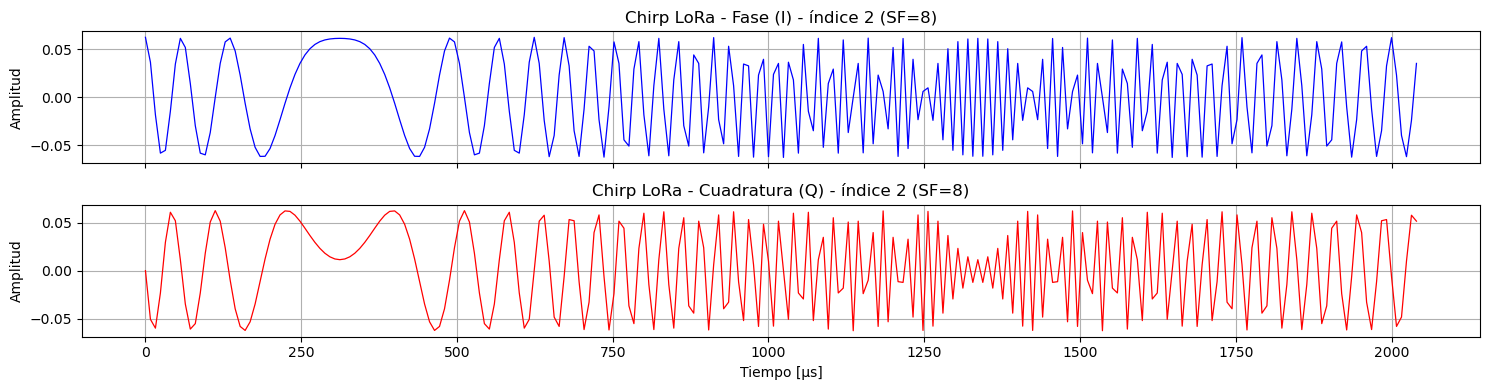

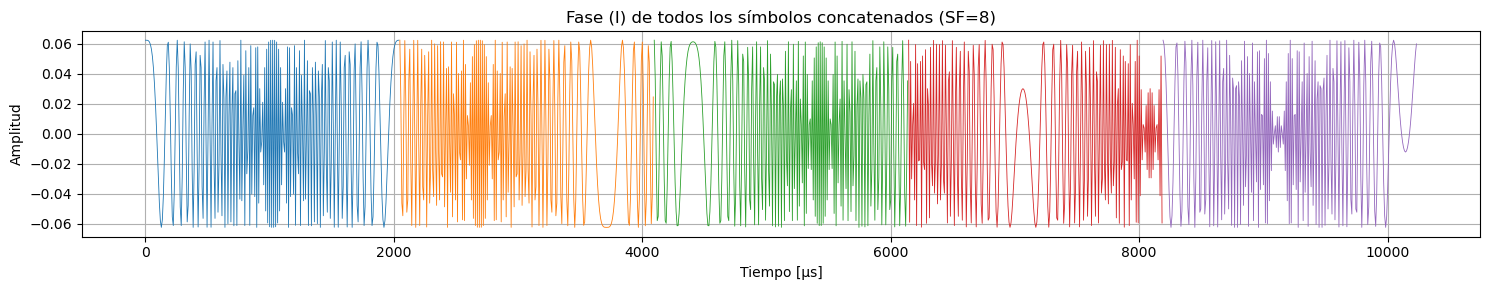

In [67]:
B = 125e3  # Ancho de banda en Hz

# Conformador de onda para los s√≠mbolos recibidos
simbolos_modulados = conformador_de_onda(simbolos_rx, SF, B)

graficar_se√±al_modulada(simbolos_modulados, 2, SF,B)
#grafica_frecuencia_se√±al_modulada(simbolos_modulados, 2, SF,B)

graficar_todas_las_senales_moduladas(simbolos_modulados, SF, B, max_muestras=5)
#graficar_frecuencia_todas_las_se√±ales_moduladas(simbolos_modulados, SF, B)


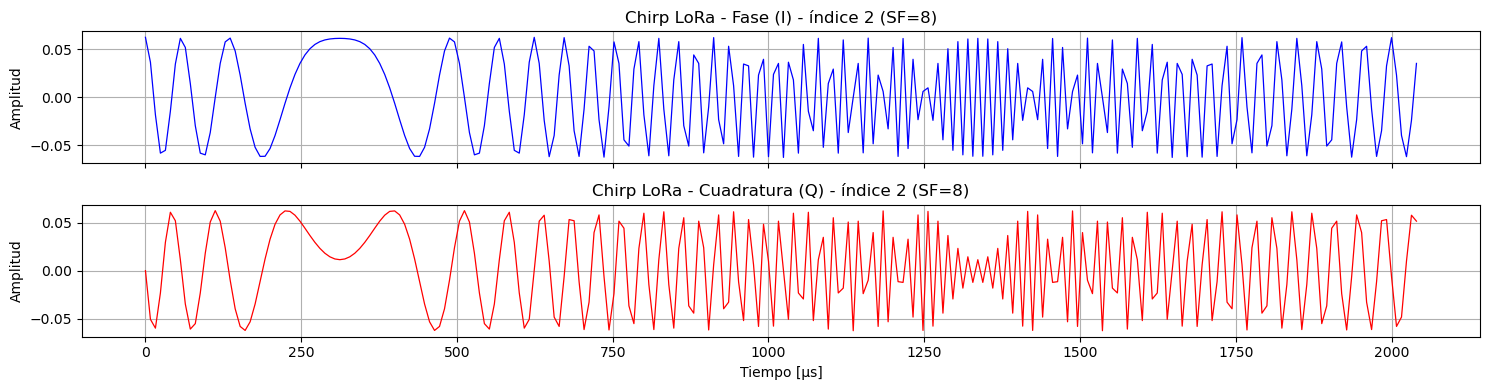

In [68]:
graficar_se√±al_modulada(simbolos_modulados, 2, SF,B)


In [69]:
simbolos_rx = formador_de_ntuplas(simbolos_modulados, SF)
print("---" * 10)
print("Salida del conformador de onda: ", simbolos_rx)
print("---" * 10)


------------------------------
Salida del conformador de onda:  [0, 48, 217, 141, 12, 186, 125, 202, 5, 140, 191, 0, 185, 35, 237, 16, 7, 202, 36, 78, 190, 243, 22, 249, 51, 9, 58, 21, 226, 50, 131, 202, 92, 181, 12, 127, 139, 29, 201, 18, 235, 25, 116, 85, 28, 39, 177, 80, 53, 13, 93, 127, 131, 225, 99, 14, 52, 130, 58, 169, 3, 48, 183, 118, 251, 82, 112, 2, 110, 50, 123, 162, 150, 98, 15, 18, 237, 13, 76, 242, 91, 58, 209, 25, 146, 10, 95, 58, 135, 159, 190, 140, 48, 120, 23, 64, 30, 46, 123, 234, 226, 103, 125, 111, 14, 229, 69, 81, 215, 240, 234, 35, 177, 199, 88, 13, 117, 78, 235, 198, 121, 111, 216, 40, 103, 44, 60, 40, 217, 212, 194, 232, 101, 185, 56, 209, 229, 126, 205, 143, 207, 60, 245, 140, 53, 249, 58, 162, 67, 51, 178, 67, 137, 17, 72, 101, 226, 9, 206, 206, 221, 3, 109, 208, 181, 38, 53, 80, 47, 113, 69, 54, 32, 80, 165, 249, 212, 226, 129, 51, 161, 18, 78, 19, 163, 125, 244, 253, 203, 117, 3, 86, 53, 56, 145, 58, 107, 101, 72, 135, 48, 242, 246, 123, 204, 185, 201, 119,

In [70]:
print("---" * 10)
print("S√≠mbolos codificados:", simbolos_rx)
print("S√≠mbolos recibidos:", simbolos_rx)
print("La tasa de error de simbolos (SER) es: ",calculador_ser(simbolos_rx, simbolos_rx) * 100,"%",)
print("---" * 10)


------------------------------
S√≠mbolos codificados: [0, 48, 217, 141, 12, 186, 125, 202, 5, 140, 191, 0, 185, 35, 237, 16, 7, 202, 36, 78, 190, 243, 22, 249, 51, 9, 58, 21, 226, 50, 131, 202, 92, 181, 12, 127, 139, 29, 201, 18, 235, 25, 116, 85, 28, 39, 177, 80, 53, 13, 93, 127, 131, 225, 99, 14, 52, 130, 58, 169, 3, 48, 183, 118, 251, 82, 112, 2, 110, 50, 123, 162, 150, 98, 15, 18, 237, 13, 76, 242, 91, 58, 209, 25, 146, 10, 95, 58, 135, 159, 190, 140, 48, 120, 23, 64, 30, 46, 123, 234, 226, 103, 125, 111, 14, 229, 69, 81, 215, 240, 234, 35, 177, 199, 88, 13, 117, 78, 235, 198, 121, 111, 216, 40, 103, 44, 60, 40, 217, 212, 194, 232, 101, 185, 56, 209, 229, 126, 205, 143, 207, 60, 245, 140, 53, 249, 58, 162, 67, 51, 178, 67, 137, 17, 72, 101, 226, 9, 206, 206, 221, 3, 109, 208, 181, 38, 53, 80, 47, 113, 69, 54, 32, 80, 165, 249, 212, 226, 129, 51, 161, 18, 78, 19, 163, 125, 244, 253, 203, 117, 3, 86, 53, 56, 145, 58, 107, 101, 72, 135, 48, 242, 246, 123, 204, 185, 201, 119, 209, 76, 

---

## 3. Canal

En este apartado se utilizaran dos tipos de canales simulados
- Canal **AWGN**
- Canal **Selectivo en Frecuencia**

Con el fin de verificar y validar el funcionamiento del software realizado para posteriormente llevarlo a una implementancion en un canal real

### 3.1 Canal AWGN

El primer canal a simular es el **canal AWGN** el cual suma un ruido blanco gaussiano a la se√±al transmitida, ruido que tiene una distribucion normal con media cero y varianza $\sigma^2$. El modelo matematico propuesto por Vangelista es el siguiente:

$$r(nT_s+kT)=c(nT_s +kT)+w(nT_s +kT)$$

Donde:

- $ùëê(ùëõùëá_ùë†+ùëòùëá)$ : es la se√±al chirp transmitida para el s√≠mbolo $ùë†$
- $ùë§(ùëõùëá_ùë†+ùëòùëá)$ : es ruido blanco gaussiano complejo
- $r(nT_s+kT)$ : es la se√±al recibida

La se√±al transmitida es una secuencia de muestras complejas (un chirp), y a cada muestra le suma un valor complejo aleatorio. Ahora simularemos el canal AWGN sin el componente de filtrado del canal, es decir, unicamente agregando ruido al a se√±al.

#### 3.1.1 Obtencion de la potencia del ruido a partir de la SNR

La potencia de una se√±al aleatoria $x$ se define como:

$$P_x = \mathbb{E}[|x|^2]$$

Donde $|x|^2 = x.x^*$, producto de $x$ por su conjugado. 

Desarrollando la expresion:

$$P_x=\mathbb{E}[(x - \mu +\mu)^2] =\mathbb{E}[(x - \mu)^2] + |\mu|^2 + 2\cdot \mathbb{E}[x - \mu]$$

Donde:

$2\cdot \mathbb{E}[x - \mu]=2 (\mathbb{E}[x]‚àí\mathbb{E}[\mu])=2\cdot (\mu-\mu)=0$

$\mathbb{E}[(x - \mu)^2]=Var(x)$

Entonces:

$$P_x = \mathbb{E}[|x|^2]=\text{Var}(x) + |\mu|^2$$

Ecuacion que utilizaremos para calcular la potencia de la se√±al transmitida

Si la media es cero ($\mu=0$):

$$P_x = \text{Var}(x) = \sigma^2$$

Ecuacion utilizada para calcular la potencia de ruido al ser un canal AWGN

En AWGN, las partes real e imaginaria son independientes e id√©nticamente distribuidas cada una con varianza $\frac{\sigma^2}{2}$, si $x = a + jb$ entonces $P_x = Var(a) + Var(b)= \frac{\sigma^2}{2} + \frac{\sigma^2}{2}  = \sigma^2$

Para modelar el canal se utiliza un ruido complejo con distribucion normal, cuya desviacion estandar para la parte real e imaginaria que cumpla la descripcion matematica anterior es:

$$\sigma = \sqrt{\frac{Potencia_{Ruido}}{2}}$$

In [71]:
def canal_AWGN(signal, pot_ruido):
    """
    Simula un canal AWGN. Con media cero y varianza pot_ruido/2.

    Args
        signal (array)
        pot_ruido (int)
    
    Return
        Se√±al + Ruido (array)
    """
    # el parametro que requiere la funcion random.normal es el desvio estandar, el cual es la raiz cuadrada de la potencia
    # la potencia es divida en 2 porque el ruido es complejo (I y Q)
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal.shape) + 1j * np.random.normal(0, desv_est, size=signal.shape)
    return signal + ruido


La Relacion Se√±al Ruido se define como $SNR = \frac{P_s}{P_n}$ siendo $P_s$ la potencia de la se√±al y $P_n$ la potencia del ruido. Para calcular la SNR en decibelios se utiliza la siguiente formula

$$\large \text{SNR}_{dB}=10\cdot log(\frac{P_s}{P_n})$$

Despejando, la potencia de Ruido se puede calcular realizando

$$\large P_n=\frac{P_s}{10^{\frac{\text{SNR}_{dB}}{10}}}$$

In [72]:
def potencias_de_ruido(pot_signal, lim_inf=-12, lim_sup=0):
    """
    Calcula el rango de potencias de ruido en escala lineal para un rango de SNR en dB.

    Args:
        pot_signal (float): Potencia de la se√±al en escala lineal.
        lim_inf (int, optional): Valor de SNR inferior. Defaults to -12.
        lim_sup (int, optional): Valor de SNR superior. Defaults to -1.

    Returns:
        list: lista de SNR en dB
        list: lista de potencias de ruido.
    """
    snr_db = np.arange(lim_inf, lim_sup + 1, 1)
    pot_ruido = pot_signal / (10 ** (snr_db / 10))
    return snr_db, pot_ruido


Se plantea una funcion la cual grafica la modulacion chirp para un simbolo y se superpone con la misma chirp pero con el ruido del canal AWGN

In [73]:
def graficar_chirp_con_y_sin_ruido(simbolos_modulados, indice, SF, B, pot_ruido):
    """
    Grafica la parte real o imaginaria del chirp LoRa con y sin ruido.

    Args:
        simbolos_modulados (Array): Lista de s√≠mbolos modulados en forma de chirps.
        indice (int): √çndice del s√≠mbolo a graficar.
        SF (int): Spreading Factor.
        B (float): Ancho de banda en Hz.
        pot_ruido (float): Potencia de ruido (en escala lineal).
    """
    simbolo = simbolos_modulados[indice]
    simbolo_con_ruido = canal_AWGN(simbolo, pot_ruido)

    num_muestras = len(simbolo)
    Ts = (2**SF) / B # Duraci√≥n total de un chirp
    T_muestra = Ts / num_muestras # Duraci√≥n de una muestra
    tiempo = np.arange(num_muestras) * T_muestra * 1e6  # Tiempo en Œºs

    sin_ruido = np.real(simbolo)
    con_ruido = np.real(simbolo_con_ruido)
    titulo_parte = "Parte Real"

    plt.figure(figsize=(12, 4))
    plt.plot(tiempo, sin_ruido, label='Sin Ruido', linewidth=1.2, color='blue')
    plt.plot(tiempo, con_ruido, label='Con Ruido', linewidth=1.2, color='orange', alpha=0.7)
    plt.title(f"Chirp LoRa - {titulo_parte} - √çndice {indice} (SF={SF})", fontsize=14, weight='bold')
    plt.xlabel("Tiempo [Œºs]")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


#### 3.1.2 Canal Flat

La modulacion FSCM esta realizada sobre un **canal plano (Flat)** con la suma de ruido gaussiano blanco (AWGN). Un canal plano en frecuencia es un canal cuya respuesta en frecuencia es constante dentro del ancho de banda de la se√±al, no hay distorsi√≥n selectiva: todos los componentes de frecuencia de la se√±al se ven afectados igual. 

### 3.2 Canal selectivo en frecuencia

El modelo de canal selectivo en frecuencia que propone Vangelista es un canal _multipath_ (de multiples trayectorias) lo que este canal modela es que la se√±al rebota en objetos del entorno (paredes, √°rboles, etc.) y llega al receptor con varios retardos y distintas potencias, de esta manera distorsiona la se√±al, porque introduce interferencia intersimbolo (ISI). La respuesta al impulso del canal matematicamente:

$$h[nT]=\sqrt{0.8}\cdot\delta[nT]+\sqrt{0.2}\cdot\delta[nT-T]$$

Esto significa que el canal tiene dos trayectorias:
- Una se√±al principal (sin retardo) con ganancia $\sqrt{0.8}$
- Una segunda se√±al (retrasada ùëá) con ganancia $\sqrt{0.2}$

Cuya transformada de Fourier es:

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f T}$$

Donde $f=\frac{f_{real}}{f_s}$ con 
- $f_{s}$ : frecuencia de muestreo

Suponiendo $T=1$ tiempo normalizado

$$H(f)=\sqrt{0.8}+\sqrt{0.2}\cdot e^{-j2\pi f }$$

Se puede observar su efecto sobre se√±ales para distintos valores de frecuencia:

|f|magnitud de H(f)| Efecto |
|:-:|:----:|:----:|
|0.25|1| Sin interferencia|
|0.5|0.45|Maxima atenuacion|
|0.75|1|Sin interferencia|
|1|1.34|Maxima amplificacion|

Como se puede observar el filtro del canal es un filtro rechaza-banda

In [74]:
def canal_multipath(signal_in, pot_ruido):
    """
    Aplica el filtro h[n] = sqrt(0.8)Œ¥[n] + sqrt(0.2)Œ¥[n‚àí1] a cada chirp (fila) y
    agrega ruido. Se recorta para mantener la longitud original sin relleno artificial.

    Args:
        signal_in (np.ndarray): Array (n_chirps, total_muestras)
        pot_ruido (float): Potencia del ruido (lineal)

    Returns:
        np.array: Se√±al con forma (n_chirps, total_muestras)
    """
    h = np.array([np.sqrt(0.8), np.sqrt(0.2)])
    chirps_filtrados = []

    for chirp in signal_in:
        chirp_filtrado = np.convolve(chirp, h, mode="full")[: len(chirp)]
        chirps_filtrados.append(chirp_filtrado)

    signal_filtrada = np.array(chirps_filtrados)

    # Agregar ruido complejo
    desv_est = np.sqrt(pot_ruido / 2)
    ruido = np.random.normal(0, desv_est, size=signal_filtrada.shape) + 1j * np.random.normal(0, desv_est, size=signal_filtrada.shape)

    return signal_filtrada + ruido


In [75]:
def simulaciones_de_canal(bits_tx,SF,B,min_snr_AWGN,max_snr_AWGN,min_snr_multipath,max_snr_multipath,):
    """
    Simula el envio de bits a traves de un canal multipath, grafica la BER vs SNR
    
    Args:
        bits_tx (list): Bits a transmitir.
        SF (int): Spreading Factor.
        samples_per_chirp (int): Muestras por chirp o factor de oversampling.
        B (int): Ancho de banda en Hz.
        min_snr (int): SNR m√≠nima en dB.
        max_snr (int): SNR m√°xima en dB.
    """
    # 1. Codificacion
    simbolos_tx = codificador(SF, bits_tx)

    # 2. Modulacion
    simbolos_modulados = conformador_de_onda(simbolos_tx, SF, B)

    # 3. Calcular potencia de la se√±al
    pot_signal = np.var(simbolos_modulados) + (np.mean(np.abs(simbolos_modulados))) ** 2

    # 4. Generar SNR y potencias de ruido
    snr_db_AWGN, pot_ruido_AWGN = potencias_de_ruido(pot_signal, min_snr_AWGN, max_snr_AWGN)
    snr_db_multipath, pot_ruido_multipath = potencias_de_ruido(pot_signal, min_snr_multipath, max_snr_multipath)

    # 5. Simular canal y demodular para cada SNR
    ber_values_AWGN = []
    ber_values_multipath = []
    i = 1
    print("---"*10)
    print("BER VS CANAL AWGN")
    for pn in pot_ruido_AWGN:
        simbolos_con_ruido_AWGN = canal_AWGN(simbolos_modulados, pn)
        simbolos_rx_AWGN = formador_de_ntuplas(simbolos_con_ruido_AWGN, SF)
        bits_rx_AWGN = decodificador(simbolos_rx_AWGN, SF)
        ber_AWGN = calculador_ber(bits_tx, bits_rx_AWGN)
        print(f" Punto {i} - BER: {ber_AWGN}")
        ber_values_AWGN.append(ber_AWGN)
        i += 1
    print("---"*10)
    print("BER VS CANAL SELECTIVO EN FRECUENCIA")
    j = 1
    for pn in pot_ruido_multipath:
        simbolos_con_ruido_multipath = canal_multipath(simbolos_modulados, pn)
        simbolos_rx_multipath = formador_de_ntuplas(simbolos_con_ruido_multipath, SF)
        bits_rx_multipath = decodificador(simbolos_rx_multipath, SF)
        ber_multipath = calculador_ber(bits_tx, bits_rx_multipath)
        print(f"Punto {j} - BER: {ber_multipath}")
        ber_values_multipath.append(ber_multipath)
        j += 1
    print("---"*10)
    # 6. Graficar
    plt.figure(figsize=(6, 4))
    plt.semilogy(snr_db_AWGN, ber_values_AWGN, "s-r", label="Flat FSCM", linewidth=0.8)
    plt.semilogy(snr_db_multipath, ber_values_multipath, "D-b", label="Freq. sel. FSCM", linewidth=0.8)
    plt.xlim(-12, -1)
    plt.ylim(10**-5, 10**-1)
    plt.xticks(np.arange(-12, 0, 1))
    plt.title("BER vs SNR")
    plt.xlabel("SNR [dB]")
    plt.ylabel("BER")
    plt.grid(True, linestyle="--", which="both")
    plt.legend()
    plt.tight_layout()
    plt.show()


### 3.3 Ejemplo

Para empezar se grafica la modulacion chirp para un simbolo especifico y se superpone al mismo chirp pero con el ruido del canal AWGN

In [76]:
# Calcular potencia de se√±al y obtener potencia de ruido
pot_signal = np.mean(np.abs(simbolos_modulados[indice])**2)
_, pot_ruidos = potencias_de_ruido(pot_signal, lim_inf=0, lim_sup=0)
pot_ruido = pot_ruidos[0] 


NameError: name 'indice' is not defined

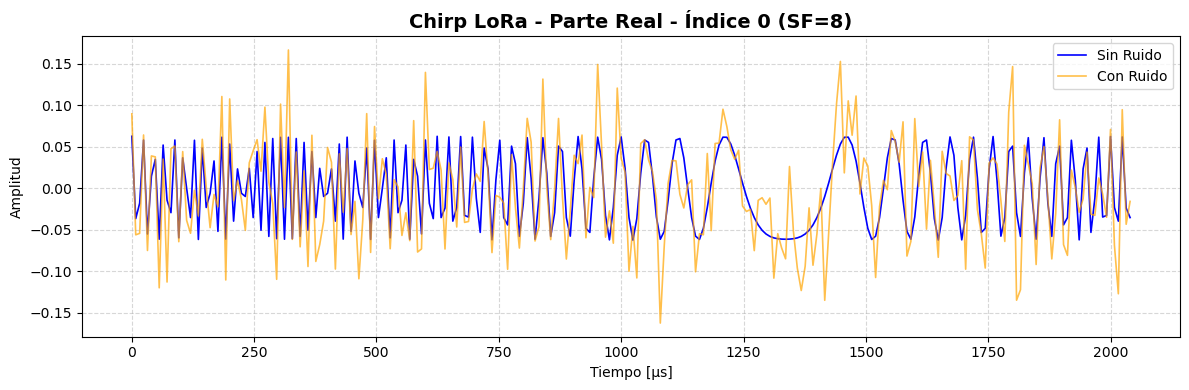

In [ ]:
graficar_chirp_con_y_sin_ruido(simbolos_modulados, indice, SF, B, pot_ruido)


Ahora si, se simularan ambos canales AWGN y Selectivo en frecuencia, se realiza la grafica del BER vs SNR

In [ ]:
# Configuraci√≥n/Parametros
cant_simbolos = 50000
total_bits = SF * cant_simbolos


In [ ]:
# Generaci√≥n de bits aleatorios
bits_tx = generate_random_bits(total_bits)


------------------------------
BER VS CANAL AWGN
 Punto 1 - BER: 0.02744
 Punto 2 - BER: 0.0082675
 Punto 3 - BER: 0.0014425
 Punto 4 - BER: 0.000285
------------------------------
BER VS CANAL SELECTIVO EN FRECUENCIA
Punto 1 - BER: 0.030285
Punto 2 - BER: 0.0115375
Punto 3 - BER: 0.003835
Punto 4 - BER: 0.001375
Punto 5 - BER: 0.0005225
Punto 6 - BER: 0.0001475
Punto 7 - BER: 2e-05
------------------------------


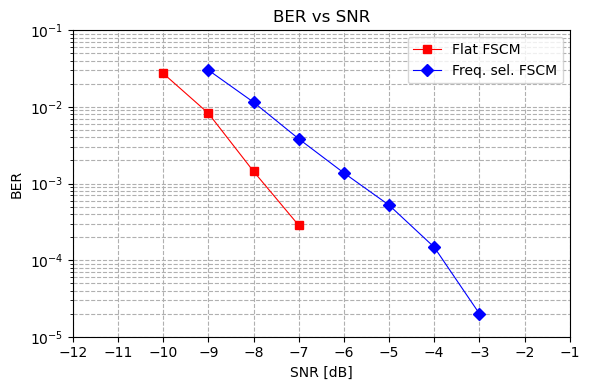

In [ ]:
# Simulaci√≥n del canal AWGN y multipath y graficar BER vs SNR
simulaciones_de_canal(bits_tx, SF, B, -10, -7, -9, -3)


En esta grafica vemos la relacion entre la tasa de bit errados vs la relacion se√±al ruido en db. Una relacion se√±al ruido igual a 0 nos dice que la potencia de la se√±al es igual a la potencia de ruido del canal. Una relacion se√±al ruido negativa nos indica que la potencia de ruido del canal es mayor que la potencia de la se√±al,lo que vemos que influye ne la tasa de bits errados al momento de la recepcion. 

En el paper de Vangelista se realiza la comparacion de la modulacion FSCM contra la modulacion FSK, y vimos que en el canal con ruido blanco gaussiano, no hay diferencia entre estas dos modulaciones al momento de aumentar la potencia de ruido y comparar su taza de error. Lo bueno de la modulacion FSCM contra la FSK viene al momento de compararlas en un canal selectivo en frecuencia, la modulacion de LoRa es mucho mas tolerante/resistente al ruido en comparacion de la modulacion FSK

# Referencias

[1] "Frequency Shift Chirp Modulation: The LoRa Modulation" ‚Äì Lorenzo Vangelista

[2] "From Demodulation to Decoding: Toward Complete LoRa PHY Understanding and Implementation" ‚Äì Zhenqiang Xu, Shuai Tong, Pengjin Xie y Jiliang Wang

[3] "Principles of Digital Communication" - Bixio Rimoldi